### Imports

In [6]:
from data_process.data import Data
from data_process.signal_tools import signal_filter
from data_process.utils import figure_reset_scale
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

### Load and filter data

In [7]:
pickle_file = '/home/ntkot/theses/ros/bag_db/data_07_10_2023__17_42_10/rosbag2_07_10_2023__17_42_10/rosbag2_07_10_2023__17_42_10.pkl'

original_data = Data(pickle_file)

sample_rate = 1 / np.average(original_data['time']['rel'][1:] - original_data['time']['rel'][0:-1])
print(f'Sample rate: {sample_rate:.3f}Hz')

accel_wiener_window = 21
accel_highpass_order = 3
accel_highpass_critical_frequency = 3

gyro_wiener_window = 21
gyro_highpass_order = 3
gyro_highpass_critical_frequency = 3

accel_wiener = lambda x: signal_filter.wiener(x, accel_wiener_window)
gyro_wiener  = lambda x: signal_filter.wiener(x, gyro_wiener_window)

accel_filter = lambda x: signal_filter.butterworth(signal=x, 
                                                   sample_rate=sample_rate, 
                                                   order=accel_highpass_order,
                                                   critical_freq=accel_highpass_critical_frequency,
                                                   btype='highpass')
gyro_filter  = lambda x: signal_filter.butterworth(signal=x, 
                                                   sample_rate=sample_rate, 
                                                   order=gyro_highpass_order, 
                                                   critical_freq=gyro_highpass_critical_frequency,
                                                   btype='highpass')

wiener_data = original_data.transform(accel_wiener, [['accel', 'x'], ['accel', 'y'], ['accel', 'z']])
wiener_data.transform(gyro_wiener,  [['gyro', 'x'],  ['gyro', 'y'],  ['gyro', 'z']], in_place=True)

final_data = wiener_data.transform(accel_filter, [['accel', 'x'], ['accel', 'y'], ['accel', 'z']])
final_data.transform(gyro_filter,  [['gyro', 'x'],  ['gyro', 'y'],  ['gyro', 'z']], in_place=True)

data_dict = {'original': original_data, 'wiener': wiener_data, 'final': final_data}

Loading from pickle file...
Sample rate: 99.949Hz


### Before vs After filtering

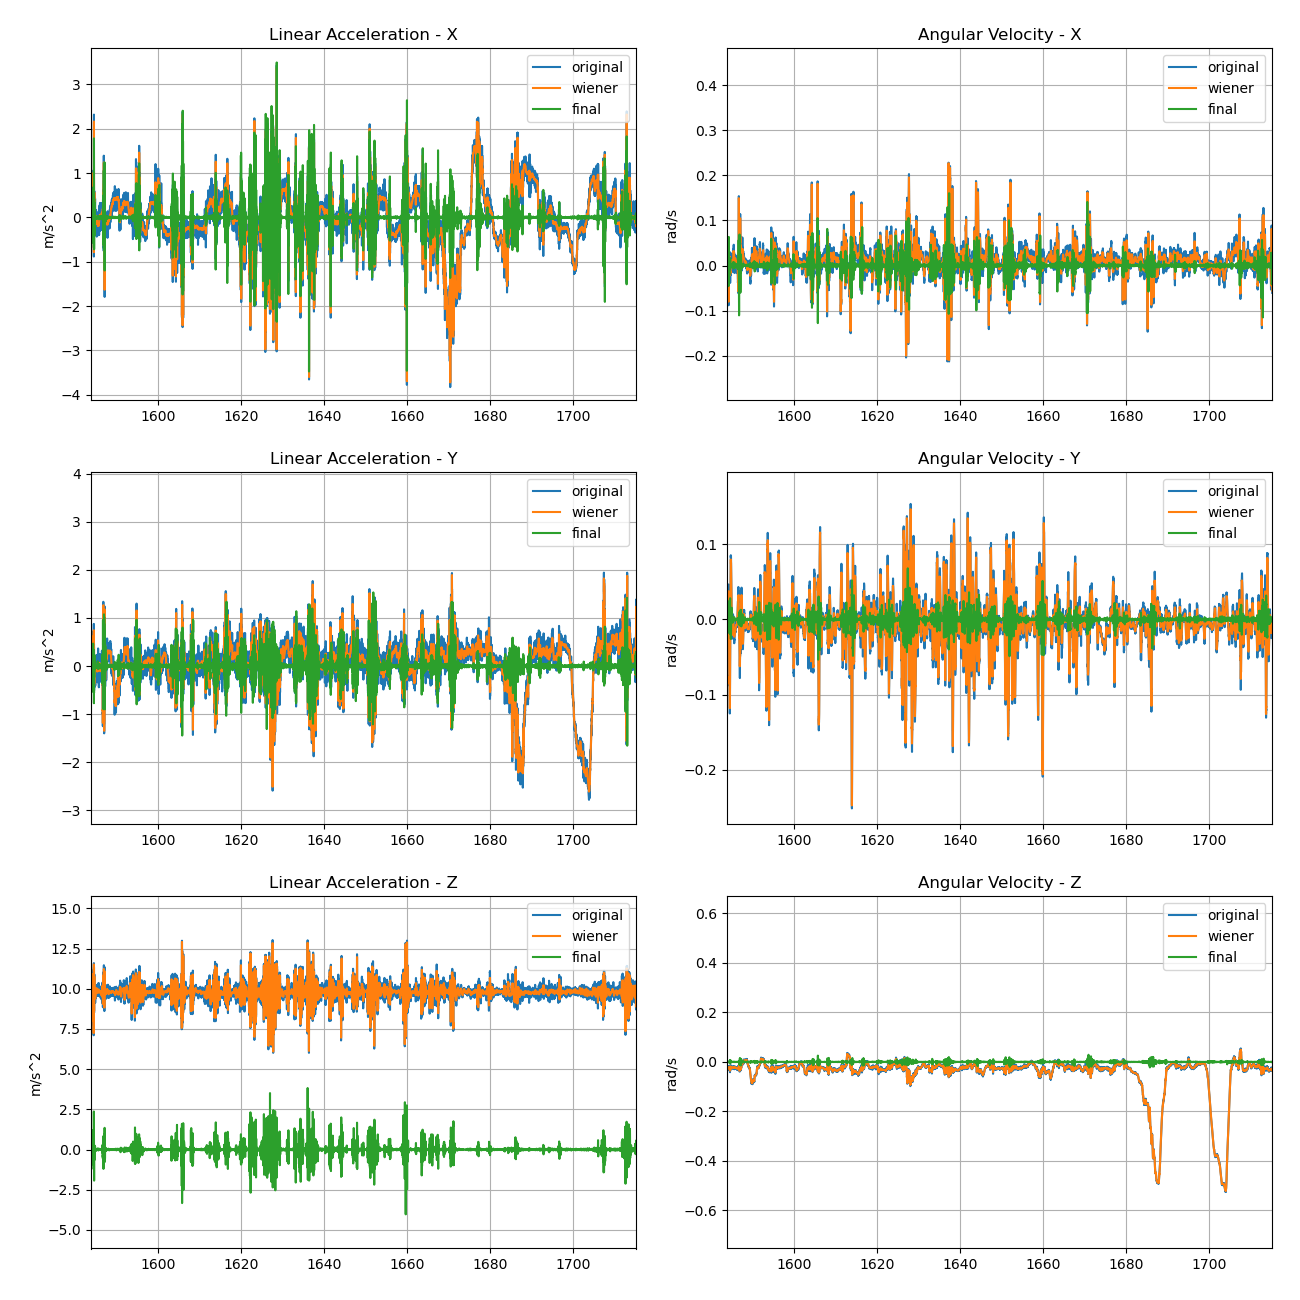

In [8]:
# If figure was created before, keep same x/y axis limits to allow for fast comparisons in time segments
compare_ax_x_lim = None
compare_ax_y_lim = None
if 'compare_ax' in locals():
    compare_ax_x_lim = compare_ax[0][0].get_xlim()
    compare_ax_y_lim = compare_ax[0][0].get_ylim()

compare_fig = plt.figure(1)
compare_fig.clear()
compare_fig, compare_ax = plt.subplots(num=1, nrows=3, ncols=2, sharex='all')

for key in data_dict.keys():
    compare_ax[0][0].plot(data_dict[key]['time']['rel'], data_dict[key]['accel']['x'], label=key)
compare_ax[0][0].grid(which='both', axis='both')
compare_ax[0][0].legend(loc='upper right')
compare_ax[0][0].tick_params(labelbottom=True)
compare_ax[0][0].set_ylabel('m/s^2')
compare_ax[0][0].set_title('Linear Acceleration - X')

for key in data_dict.keys():
    compare_ax[1][0].plot(data_dict[key]['time']['rel'], data_dict[key]['accel']['y'], label=key)
compare_ax[1][0].grid(which='both', axis='both')
compare_ax[1][0].legend(loc='upper right')
compare_ax[1][0].tick_params(labelbottom=True)
compare_ax[1][0].set_ylabel('m/s^2')
compare_ax[1][0].set_title('Linear Acceleration - Y')

for key in data_dict.keys():
    compare_ax[2][0].plot(data_dict[key]['time']['rel'], data_dict[key]['accel']['z'], label=key)
compare_ax[2][0].grid(which='both', axis='both')
compare_ax[2][0].legend(loc='upper right')
compare_ax[2][0].tick_params(labelbottom=True)
compare_ax[2][0].set_ylabel('m/s^2')
compare_ax[2][0].set_title('Linear Acceleration - Z')

for key in data_dict.keys():
    compare_ax[0][1].plot(data_dict[key]['time']['rel'], data_dict[key]['gyro']['x'], label=key)
compare_ax[0][1].grid(which='both', axis='both')
compare_ax[0][1].legend(loc='upper right')
compare_ax[0][1].tick_params(labelbottom=True)
compare_ax[0][1].set_ylabel('rad/s')
compare_ax[0][1].set_title('Angular Velocity - X')

for key in data_dict.keys():
    compare_ax[1][1].plot(data_dict[key]['time']['rel'], data_dict[key]['gyro']['y'], label=key)
compare_ax[1][1].grid(which='both', axis='both')
compare_ax[1][1].legend(loc='upper right')
compare_ax[1][1].tick_params(labelbottom=True)
compare_ax[1][1].set_ylabel('rad/s')
compare_ax[1][1].set_title('Angular Velocity - Y')

for key in data_dict.keys():
    compare_ax[2][1].plot(data_dict[key]['time']['rel'], data_dict[key]['gyro']['z'], label=key)
compare_ax[2][1].grid(which='both', axis='both')
compare_ax[2][1].legend(loc='upper right')
compare_ax[2][1].tick_params(labelbottom=True)
compare_ax[2][1].set_ylabel('rad/s')
compare_ax[2][1].set_title('Angular Velocity - Z')

compare_fig.set_size_inches(13,13)
compare_fig.tight_layout(pad=2)

if (compare_ax_x_lim is not None) and (compare_ax_y_lim is not None):
    compare_ax[0][0].set_xlim(compare_ax_x_lim)
    compare_ax[0][0].set_ylim(compare_ax_y_lim)

compare_fig.canvas.mpl_connect('key_press_event', lambda event: figure_reset_scale(event, compare_ax[0][0]))

plt.show()

### Dynamic threshold on filtered data

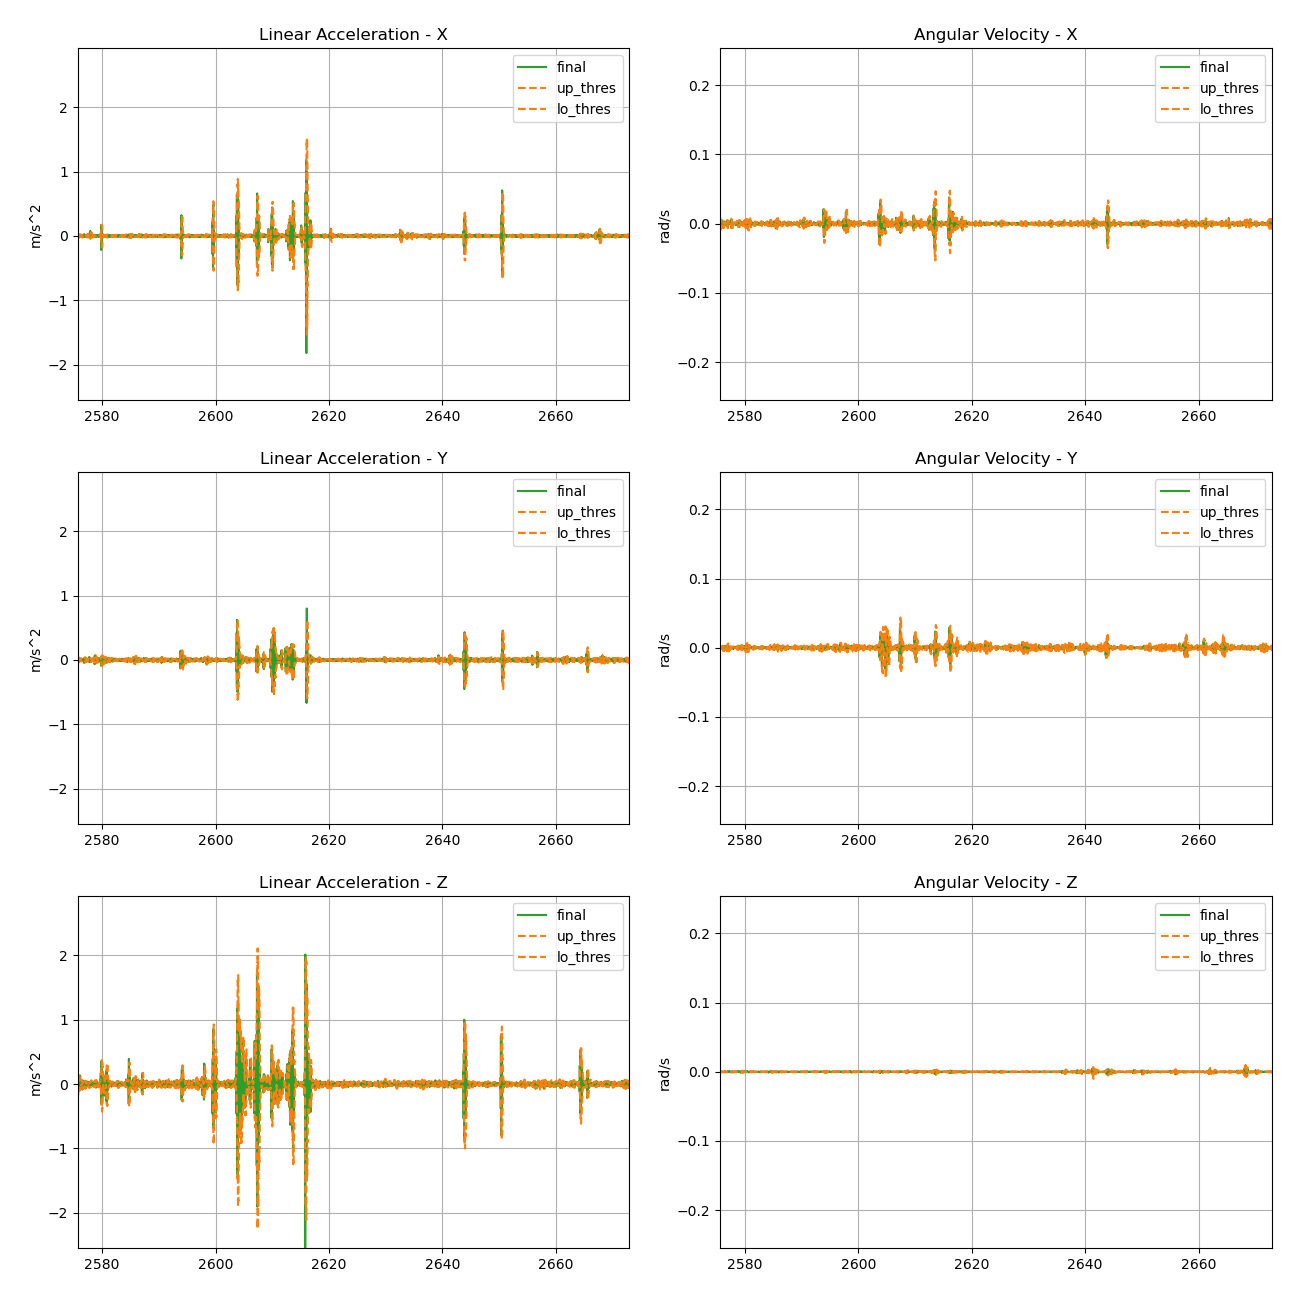

In [9]:
dynamic_threshold_window   = 20
dynamic_threshold_std_gain = 2
dynamic_threshold_min      = 0.0

upper_thres = lambda x: np.clip(signal_filter.moving_average(x, dynamic_threshold_window) + \
                                signal_filter.moving_std(x, dynamic_threshold_window) * dynamic_threshold_std_gain, dynamic_threshold_min, None)
lower_thres = lambda x: np.clip(signal_filter.moving_average(x, dynamic_threshold_window) - \
                                signal_filter.moving_std(x, dynamic_threshold_window) * dynamic_threshold_std_gain, None, -dynamic_threshold_min)

dyn_thres_ax_x_lim = None
dyn_thres_ax_y_lim = None
if 'dyn_thres_ax' in locals():
    dyn_thres_ax_x_lim = dyn_thres_ax[0][0].get_xlim()
    dyn_thres_ax_y_lim = dyn_thres_ax[0][0].get_ylim()

dyn_thres_fig = plt.figure(2)
dyn_thres_fig.clear()
dyn_thres_fig, dyn_thres_ax = plt.subplots(num=2, nrows=3, ncols=2, sharex='all')

dyn_thres_ax[0][0].plot(final_data['time']['rel'], final_data['accel']['x'], color='#2ca02c', label='final')
dyn_thres_ax[0][0].plot(final_data['time']['rel'], upper_thres(final_data['accel']['x']), label='up_thres', color='#ff7f0e', linestyle='--')
dyn_thres_ax[0][0].plot(final_data['time']['rel'], lower_thres(final_data['accel']['x']), label='lo_thres', color='#ff7f0e', linestyle='--')
dyn_thres_ax[0][0].grid(which='both', axis='both')
dyn_thres_ax[0][0].legend(loc='upper right')
dyn_thres_ax[0][0].tick_params(labelbottom=True)
dyn_thres_ax[0][0].set_ylabel('m/s^2')
dyn_thres_ax[0][0].set_title('Linear Acceleration - X')

dyn_thres_ax[1][0].plot(final_data['time']['rel'], final_data['accel']['y'], color='#2ca02c', label='final')
dyn_thres_ax[1][0].plot(final_data['time']['rel'], upper_thres(final_data['accel']['y']), label='up_thres', color='#ff7f0e', linestyle='--')
dyn_thres_ax[1][0].plot(final_data['time']['rel'], lower_thres(final_data['accel']['y']), label='lo_thres', color='#ff7f0e', linestyle='--')
dyn_thres_ax[1][0].grid(which='both', axis='both')
dyn_thres_ax[1][0].legend(loc='upper right')
dyn_thres_ax[1][0].tick_params(labelbottom=True)
dyn_thres_ax[1][0].set_ylabel('m/s^2')
dyn_thres_ax[1][0].set_title('Linear Acceleration - Y')

dyn_thres_ax[2][0].plot(final_data['time']['rel'], final_data['accel']['z'], color='#2ca02c', label='final')
dyn_thres_ax[2][0].plot(final_data['time']['rel'], upper_thres(final_data['accel']['z']), label='up_thres', color='#ff7f0e', linestyle='--')
dyn_thres_ax[2][0].plot(final_data['time']['rel'], lower_thres(final_data['accel']['z']), label='lo_thres', color='#ff7f0e', linestyle='--')
dyn_thres_ax[2][0].grid(which='both', axis='both')
dyn_thres_ax[2][0].legend(loc='upper right')
dyn_thres_ax[2][0].tick_params(labelbottom=True)
dyn_thres_ax[2][0].set_ylabel('m/s^2')
dyn_thres_ax[2][0].set_title('Linear Acceleration - Z')

dyn_thres_ax[0][0].sharey(dyn_thres_ax[1][0])
dyn_thres_ax[1][0].sharey(dyn_thres_ax[2][0])

dyn_thres_ax[0][1].plot(final_data['time']['rel'], final_data['gyro']['x'], color='#2ca02c', label='final')
dyn_thres_ax[0][1].plot(final_data['time']['rel'], upper_thres(final_data['gyro']['x']), label='up_thres', color='#ff7f0e', linestyle='--')
dyn_thres_ax[0][1].plot(final_data['time']['rel'], lower_thres(final_data['gyro']['x']), label='lo_thres', color='#ff7f0e', linestyle='--')
dyn_thres_ax[0][1].grid(which='both', axis='both')
dyn_thres_ax[0][1].legend(loc='upper right')
dyn_thres_ax[0][1].tick_params(labelbottom=True)
dyn_thres_ax[0][1].set_ylabel('rad/s')
dyn_thres_ax[0][1].set_title('Angular Velocity - X')

dyn_thres_ax[1][1].plot(final_data['time']['rel'], final_data['gyro']['y'], color='#2ca02c', label='final')
dyn_thres_ax[1][1].plot(final_data['time']['rel'], upper_thres(final_data['gyro']['y']), label='up_thres', color='#ff7f0e', linestyle='--')
dyn_thres_ax[1][1].plot(final_data['time']['rel'], lower_thres(final_data['gyro']['y']), label='lo_thres', color='#ff7f0e', linestyle='--')
dyn_thres_ax[1][1].grid(which='both', axis='both')
dyn_thres_ax[1][1].legend(loc='upper right')
dyn_thres_ax[1][1].tick_params(labelbottom=True)
dyn_thres_ax[1][1].set_ylabel('rad/s')
dyn_thres_ax[1][1].set_title('Angular Velocity - Y')

dyn_thres_ax[2][1].plot(final_data['time']['rel'], final_data['gyro']['z'], color='#2ca02c', label='final')
dyn_thres_ax[2][1].plot(final_data['time']['rel'], upper_thres(final_data['gyro']['z']), label='up_thres', color='#ff7f0e', linestyle='--')
dyn_thres_ax[2][1].plot(final_data['time']['rel'], lower_thres(final_data['gyro']['z']), label='lo_thres', color='#ff7f0e', linestyle='--')
dyn_thres_ax[2][1].grid(which='both', axis='both')
dyn_thres_ax[2][1].legend(loc='upper right')
dyn_thres_ax[2][1].tick_params(labelbottom=True)
dyn_thres_ax[2][1].set_ylabel('rad/s')
dyn_thres_ax[2][1].set_title('Angular Velocity - Z')

dyn_thres_ax[0][1].sharey(dyn_thres_ax[1][1])
dyn_thres_ax[1][1].sharey(dyn_thres_ax[2][1])

dyn_thres_fig.set_size_inches(13,13)
dyn_thres_fig.tight_layout(pad=2)

if (dyn_thres_ax_x_lim is not None) and (dyn_thres_ax_y_lim is not None):
    dyn_thres_ax[0][0].set_xlim(dyn_thres_ax_x_lim)
    dyn_thres_ax[0][0].set_ylim(dyn_thres_ax_y_lim)

dyn_thres_fig.canvas.mpl_connect('key_press_event', lambda event: figure_reset_scale(event, dyn_thres_ax[0][0]))

plt.show()